In [1]:
import pandas as pd
import numpy as np
from pybnesian import hc, HeterogeneousBNType, GaussianNetwork, CLGNetwork, CLGNetworkType, KDENetworkType
from scipy.stats import rv_discrete
from drawdata import draw_scatter
import matplotlib.pyplot as plt
import math


In [2]:
#draw_scatter()

In [3]:
#df = pd.read_clipboard(sep=",")
#df.to_csv("toy-2class.csv", index = False)

In [4]:
df = pd.read_csv("toy-3class.csv")

In [5]:
df["class"] = df["z"].astype('category')
#df["z"] = df["z"].astype('category')
df = df.drop("z", axis = 1 )


learned = hc(df, bn_type = CLGNetworkType(), operators = ["arcs"], score = "validated-lik")
learned.num_arcs()

learned.fit(df)

In [6]:
factor = learned.cpd("class")

In [7]:
factor.parent_values()

[]

In [8]:
synt = learned.sample(1000).to_pandas()

In [9]:
synt[synt["class"] == "c"].count()

class    182
y        182
x        182
dtype: int64

In [10]:
def euclidean_distance(x_cfx, x_og) :
    # Make sure attributes go in the same order
    #x_og = x_og[x_cfx.index]
    
    # Return Euclidean distance
    return np.sqrt(np.sum((x_cfx-x_og).values**2))

def delta_distance(x_cfx, x_og) :
    pass

def likelihood(x_cfx,bn) :
    class_cpd = bn.cpd("class")
    class_values = class_cpd.variable_values()
    cfx = x_cfx.copy()
    likelihood = 0
    for v in class_values :
        cfx["class"] = pd.Categorical([v], categories = class_values)
        likelihood = likelihood + math.e**bn.logl(cfx)
    return likelihood

def accuracy(x_cfx, y_og, bn) :
    class_cpd = bn.cpd("class")
    class_values = class_cpd.variable_values()
    cfx = x_cfx.copy()
    prob = 0
    for v in class_values :
        if v != y_og :
            cfx["class"] = pd.Categorical([v], categories = class_values)
            prob = prob + math.e**bn.logl(cfx)
    ll = likelihood(x_cfx,bn)
    if ll>0 :
        return prob/likelihood(x_cfx,bn)
    else :
        return 1


def path(x_cfx, x_og, bn) :
    pass



In [11]:
learned.slogl(synt.iloc[[100]])

-11.657973445704627

In [12]:
euclidean_distance(synt.iloc[0].drop("class"), synt.iloc[2].drop("class"))

360.5772314367417

In [13]:
synt.iloc[[0]]#.drop("class", axis = 1)

,class,y,x
0,c,384.720621,422.12262


In [79]:
learned.cpd("y")

[CLinearGaussianCPD] P(y | class)
+-------+--------------------------------------------------+
|       |                        y                         |
+-------+--------------------------------------------------+
| class |                                                  |
+-------+--------------------------------------------------+
|   a   | [LinearGaussianCPD] P(y) = N(210.809, 20024.579) |
|   b   |  [LinearGaussianCPD] P(y) = N(50.340, 579.054)   |
|   c   |  [LinearGaussianCPD] P(y) = N(422.662, 686.162)  |
+-------+--------------------------------------------------+

In [15]:
x_cfx = synt.iloc[[300]].copy()
#x_cfx = x_cfx.drop("class",axis = 1)
x_cfx["x"] = [192.069]
x_cfx.loc[x_cfx.index]["y"] = 444.152 + -1.215*192.069
x_cfx.loc[x_cfx.index]["class"] = pd.Categorical(["a"], categories = ["a","b","c"])
print(x_cfx)

    class           y        x
300     a  441.427157  192.069


In [16]:
print(math.e**learned.cpd("x").logl(x_cfx.drop(["y"], axis = 1)))
print(math.e**learned.cpd("y").logl(x_cfx))
print(math.e**learned.cpd("class").logl(x_cfx.drop(["x","y"], axis = 1)))

ValueError: Column "y" not found in DataFrame

In [17]:
from scipy.stats import norm

In [28]:
x = norm(192.069, np.sqrt(2554.987))
y = norm(444.152 + -1.215*192.069, np.sqrt(16335.215))

In [29]:
x.pdf(192.069)*y.pdf(444.152 + -1.215*192.069)*0.479

1.1800458182782846e-05

In [30]:
x.pdf(192.069)

0.00789252049721482

In [31]:
math.e**learned.logl(x_cfx)

array([1.17898997e-05])

In [93]:
likelihood(x_cfx,learned)

AttributeError: 'DataFrame' object has no attribute 'add_column'

In [33]:
factor.parent_values()

[]

In [19]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

In [73]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=3,
                         n_ieq_constr=2,
                         xl=np.array([0]*2),
                         xu=np.array([10000]*2))

    def _evaluate(self, x, out, *args, **kwargs):
        x_cfx = x_og.copy()
        x_cfx[:] = x
        f1 = euclidean_distance(x_cfx,x_og)
        f2 = -likelihood(x_cfx, learned)
        f3 = -accuracy(x_cfx,y_og,learned)
        out["F"] = np.column_stack([f1, f2,f3])
        
        g1 = -likelihood(x_cfx, learned)+0.00001
        g2 = -accuracy(x_cfx,y_og,learned)+0.2
        out["G"] = np.column_stack([g1,g2])

In [74]:
problem = MyProblem()

x_og = synt.iloc[[300]].copy()
print(x_og)
x_og["x"] = 192.069
x_og["y"] = 444.152 + -1.215*192.069 + np.sqrt(16335.215)
x_og = x_og.drop("class",axis = 1)
y_og = "a"
#x_cfx["class"] = pd.Categorical("a", categories = ["a","b","c"])

algorithm = NSGA2(pop_size=200)

res = minimize(problem,
               algorithm,
               ('n_gen', 30),
               seed=1,
               verbose=True)

# calculate a hash to show that all executions end with the same result
print("hash", res.F.sum())

    class           y           x
300     a  441.427157  156.647531
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  0.0000100000 |  0.0140099807 |             - |             -
     2 |      400 |      1 |  9.999999E-06 |  1.000000E-05 |             - |             -
     3 |      600 |      1 |  9.999228E-06 |  9.999995E-06 |             - |             -
     4 |      800 |      1 |  1.875182E-06 |  9.959371E-06 |             - |             -
     5 |     1000 |      1 |  1.875182E-06 |  9.944558E-06 |             - |             -
     6 |     1200 |      1 |  0.000000E+00 |  9.843601E-06 |             - |             -
     7 |     1400 |      2 |  0.000000E+00 |  9.735948E-06 |  1.0000000000 |         ideal
     8 |     1600 |      4 |  0.000000E+00 |  9.535152E-06 |  0.0314868815 |         ideal
     9 |     1800 |      4 |  0.000000E+00 |  9.134957E-06 |  0.000000E+00 |             f
    10 |     2000 |   

In [75]:
res.F

array([[ 2.32312438e+02, -1.06090823e-05, -9.99999859e-01],
       [ 5.03866204e+02, -1.25539260e-05, -1.00000000e+00],
       [ 4.99887910e+02, -1.22069760e-05, -1.00000000e+00],
       [ 2.75113989e+02, -3.38251119e-05, -1.00000000e+00],
       [ 3.19193423e+02, -1.08875909e-05, -1.00000000e+00],
       [ 4.46038907e+02, -1.33906563e-05, -1.00000000e+00],
       [ 2.34466403e+02, -1.15524281e-05, -9.99999900e-01],
       [ 2.32783947e+02, -1.06468688e-05, -9.99999912e-01],
       [ 2.35795201e+02, -1.50050990e-05, -9.99999952e-01],
       [ 2.41282920e+02, -1.50128984e-05, -9.99999979e-01],
       [ 2.38049153e+02, -1.21394740e-05, -9.99999961e-01],
       [ 2.44740493e+02, -2.09443427e-05, -9.99999989e-01],
       [ 2.50994214e+02, -2.30085028e-05, -9.99999996e-01],
       [ 2.60625354e+02, -1.83772111e-05, -9.99999999e-01],
       [ 2.88433083e+02, -2.93492371e-05, -1.00000000e+00],
       [ 2.81388006e+02, -3.22083083e-05, -1.00000000e+00],
       [ 2.75214262e+02, -3.01407866e-05

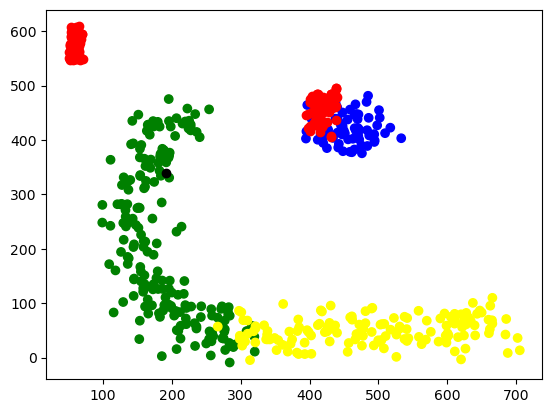

In [81]:
to_plot = df.drop("class", axis = 1)
colours = df["class"].to_numpy()
colours[colours == "a"] = "green"
colours[colours == "b"] = "yellow"
colours[colours == "c"] = "blue"
plt.scatter(to_plot["x"],to_plot["y"], color = colours)
plt.scatter(res.X.transpose()[0],res.X.transpose()[1],color = "red")
plt.scatter(x_og["x"],x_og["y"], color = "black")
plt.show()

In [58]:
res.X.transpose()

array([[282.9782019 , 435.57954636, 421.64949798, 340.71448906,
         57.21428289,  65.16204679, 400.55098326, 399.21634328,
        399.39417379, 387.55893596, 387.22424096, 399.36603519,
         67.44014535, 388.28365637, 422.12762761, 401.66382655,
         61.65062931,  49.74380037, 405.21259938, 398.08645284,
        347.17067389, 318.68170103, 415.82625692, 423.48966913,
        128.41096339,  64.50671903, 411.9869542 , 398.08645284,
        399.36824571, 399.21634328, 397.03101413, 387.55893596,
        420.6934228 , 249.00937653, 400.69339821, 358.26963701,
        399.27468395, 421.19667442, 413.16512054, 387.55893596,
        418.47127133, 239.86867421, 387.55893596, 401.39816268,
        387.75006556, 421.82231836, 400.55098326, 387.32735505,
         80.54859694, 421.58923209, 420.30410608, 398.08645284,
        387.55893596, 387.11327314, 419.97598439, 412.83316105,
         56.640607  , 411.9869542 , 399.05187921, 124.1096037 ,
        382.7869886 , 383.86097425, 398.